# CS4487 - Machine Learning
# Lecture 4b - Non-linear Classifiers
## Dr. Antoni B. Chan
### Dept. of Computer Science, City University of Hong Kong

# Outline
1. Nonlinear classifiers
2. Kernel trick and kernel SVM
3. **Ensemble Methods - Boosting, Random Forests**
4. Classification Summary

In [1]:
# setup
%matplotlib inline
import IPython.core.display         # setup output image format (Chrome works best)
IPython.core.display.set_matplotlib_formats("svg")
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
from scipy import stats

/anaconda3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV itera

In [2]:
def drawstump(fdim, fthresh, fdir='gt', poscol=None, negcol=None, lw=2, ls='k-'):
    # fdim = dimension
    # fthresh = threshold
    # fdir = direction (gt, lt)
    
    if fdir == 'lt':
        # swap colors
        tmp = poscol
        poscol = negcol
        negcol = tmp
    
    # assume fdim=0
    polyxn = [fthresh, fthresh, -30, -30]
    polyyn = [30, -30, -30, 30]
    
    polyxp = [fthresh, fthresh, 30, 30]
    polyyp = [30, -30, -30, 30]
        
    # fill positive half-space or neg space
    if (poscol):
        if fdim==0:
            plt.fill(polyxp, polyyp, poscol, alpha=0.2)
        else:
            plt.fill(polyyp, polyxp, poscol, alpha=0.2)            
    
    if (negcol):
        if fdim==0:
            plt.fill(polyxn, polyyn, negcol, alpha=0.2)
        else:
            plt.fill(polyyn, polyxn, negcol, alpha=0.2)

    # plot line
    if fdim==0:
        plt.plot(polyxp[0:2], polyyp[0:2], ls, lw=lw)
    else:
        plt.plot(polyyp[0:2], polyxp[0:2], ls, lw=lw)

def drawplane(w, b=None, c=None, wlabel=None, poscol=None, negcol=None, lw=2, ls='k-'):
    # w^Tx + b = 0
    # w0 x0 + w1 x1 + b = 0
    # x1 = -w0/w1 x0 - b / w1

    # OR
    # w^T (x-c) = 0 = w^Tx - w^Tc  --> b = -w^Tc
    if c != None:
        b = -sum(w*c)
    
    # the line
    if (abs(w[0])>abs(w[1])):   # vertical line
        x0 = array([-30,30])
        x1 = -w[0]/w[1] * x0 - b / w[1]
    else:                       # horizontal line
        x1 = array([-30,30])
        x0 = -w[1]/w[0] * x1 - b / w[0]
    
    # fill positive half-space or neg space
    if (poscol):
        polyx = [x0[0], x0[-1], x0[-1], x0[0]]
        polyy = [x1[0], x1[-1], x1[0], x1[0]]
        plt.fill(polyx, polyy, poscol, alpha=0.2)
    
    if (negcol):
        polyx = [x0[0], x0[-1], x0[0], x0[0]]
        polyy = [x1[0], x1[-1], x1[-1], x1[0]]
        plt.fill(polyx, polyy, negcol, alpha=0.2)
        
    # plot line
    lineplt, = plt.plot(x0, x1, ls, lw=lw)

    # the w
    if (wlabel):
        xp = array([0, -b/w[1]])
        xpw = xp+w
        plt.arrow(xp[0], xp[1], w[0], w[1], width=0.01)
        plt.text(xpw[0]-0.5, xpw[1], wlabel)
    return lineplt

# Ensemble Classifiers
- _Why trust only one expert?_
  - In real life, we may consult several experts, or go with the "wisdom of the crowd"  
  - In machine learning, _why trust only one classifier?_

- Ensemble methods aim to combine multiple classifiers together to form a better classifier.
- Examples:
  - **boosting** - training multiple classifiers, each focusing on errors made by previous classifiers.
  - **bagging** - training multiple classifiers from random selection of training data

# AdaBoost - Adaptive Boosting
- Base classifier is a "weak learner" 
  - A simple classifier that can be slightly better than random chance (>50%)
  - Example: _decision stump classifier_  
    - check if feature value is above (or below) a threshold.
    - $y = f(x) = \begin{cases}+1, & x_j \geq T \\ -1, & x_j\lt T \end{cases}$


In [3]:
# type three - moons
X3,Y3 = datasets.samples_generator.make_moons(n_samples=100,
                                             noise=0.1, random_state=4487)
mycmap = matplotlib.colors.LinearSegmentedColormap.from_list('mycmap', ["#FF0000", "#FFFFFF", "#00FF00"])

axbox = [-1.5, 2.5, -1, 1.5]

wlfig = plt.figure(figsize=(9,3))
plt.subplot(1,2,1)
drawstump(0, 0, poscol='g', negcol='r')
plt.scatter(X3[:,0], X3[:,1], c=Y3, cmap=mycmap, edgecolors='k')
plt.xlabel('$x_1$'); plt.ylabel('$x_2$'); plt.grid(True)
plt.axis(axbox)
plt.title('$f(\mathbf{x}) = (x_1>0)$')

plt.subplot(1,2,2)
drawstump(1, 0.5, fdir='lt', poscol='g', negcol='r')
plt.scatter(X3[:,0], X3[:,1], c=Y3, cmap=mycmap, edgecolors='k')
plt.xlabel('$x_1$'); plt.ylabel('$x_2$'); plt.grid(True)
plt.axis(axbox)
plt.title('$f(\mathbf{x}) = (x_2<0.5)$')
plt.close()

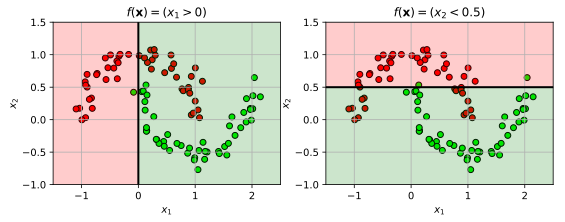

In [4]:
wlfig

- **Idea:** train weak classifiers sequentially
- In each iteration,
  - Pick a weak learner $f_t(\mathbf{x})$ that best carves out the input space.
  - The weak learner should focus on data that is misclassified.
    - Apply weights to each sample in the training data.
    - Higher weights give more priority to difficult samples.

In [5]:
def plot_boosting(model, axbox, X):

    # grid points
    xr = [ linspace(axbox[0], axbox[1], 200), 
           linspace(axbox[2], axbox[3], 200) ]

    # make a grid for calculating the posterior, 
    #  then form into a big [N,2] matrix
    xgrid0, xgrid1 = meshgrid(xr[0], xr[1])
    allpts = c_[xgrid0.ravel(), xgrid1.ravel()]

    # calculate the decision function
    score = model.decision_function(allpts).reshape(xgrid0.shape)
    maxscore = ceil(abs(score).max())
    mylevels = linspace(-maxscore, maxscore, 11)

    plt.imshow(score, origin='lower', extent=axbox, alpha=0.30, cmap=mycmap, 
               vmin=-maxscore, vmax=maxscore, aspect='auto')

    #plt.contourf(xr[0], xr[1], score, levels=mylevels, cmap=mycmap, alpha=0.3)
    plt.contour(xr[0], xr[1], score, levels=[0], linestyles='solid', colors='k',
                linewidths=2)
    
    plt.axis(axbox); plt.grid(True)    

In [6]:
plts = {}
ns = [1, 2, 3, 4, 5]
N = X3.shape[0]
XW = ones(N) / N

for n in ns:
    clf = ensemble.AdaBoostClassifier(n_estimators=n, random_state=4487)
    clf.fit(X3, Y3)

    plts[n] = plt.figure(figsize=(9,3))
    
    # show the weak learner
    wl = clf.estimators_[n-1]
    wlf = wl.tree_.feature[0]
    wlt = wl.tree_.threshold[0]

    if wl.tree_.value[2,0,1] > wl.tree_.value[2,0,0]:
        wld = 'gt'
    else:
        wld = 'lt'
    
    plt.subplot(1,2,1)
    drawstump(wlf, wlt, fdir=wld, poscol='g', negcol='r')
    mys = 20*sqrt(XW*N)
    plt.scatter(X3[:,0], X3[:,1], c=Y3, s=mys, cmap=mycmap, edgecolors='k')
    plt.xlabel('$x_1$'); plt.ylabel('$x_2$')
    plt.axis(axbox); plt.grid(True)
    plt.title('iter '+str(n) + " weak learner")

    plt.subplot(1,2,2)
    plot_boosting(clf, axbox, X3)
    plt.scatter(X3[:,0], X3[:,1], c=Y3, cmap=mycmap, edgecolors='k')

    plt.xlabel('$x_1$'); plt.ylabel('$x_2$')
    plt.title('iter '+str(n) + " classifier")
        
    # calculate updated weights (for AdaBoost)
    # can't find these in the sklearn version
    tmpY = clf.predict(X3)
    err = mean(tmpY != Y3)
    alpha = 0.5*log((1-err) / err)
    scale = 2*(tmpY!=Y3)-1
    XW = XW * exp(scale*alpha)
    XW = XW / sum(XW)
    plt.close()

# Iteration 1
- Initially, weights for all training samples are equal: $w_i = 1/N$
  - Pick best weak learner.

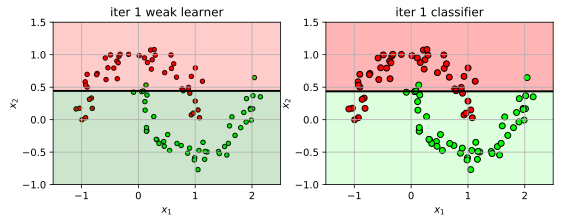

In [7]:
plts[1]

# Iteration 2
- points are re-weighted based on the current classification result:
  - increase weights of samples that are misclassified: $w_i = w_i e^{\alpha}$
  - decrease weights of correctly classified samples: $w_i = w_i e^{-\alpha}$
  - $\alpha = 0.5 \log \frac{1-err}{err}$ is based on the current classifier error.
  - (larger circles indicates higher weight)
- using the weighted data, train another weak learner $f_2(\mathbf{x})$.
- the classifier function is the weighted sum of weak learners
  - $f(\mathbf{x}) = \sum_{t=1}^D \alpha_t f_t(\mathbf{x})$

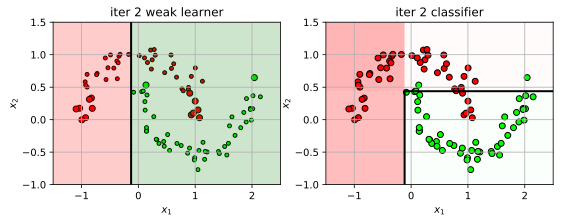

In [8]:
plts[2]

# Keep iterating...

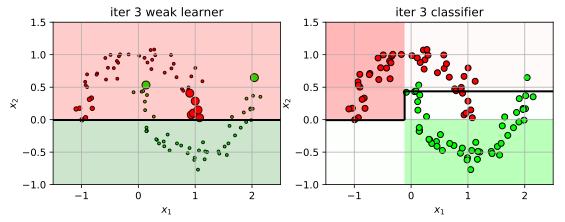

In [9]:
plts[3]

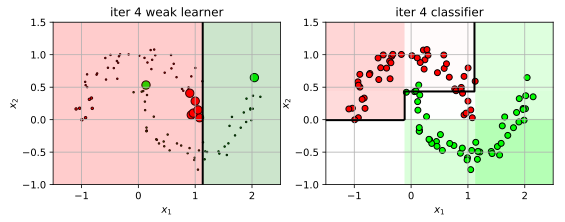

In [10]:
plts[4]

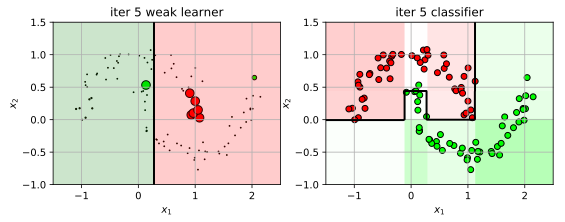

In [11]:
plts[5]

- After many iterations...

In [12]:
ns = [10, 50, 100, 1000]

adafig = plt.figure(figsize=(9,9))
for i,n in enumerate(ns):
    clf = ensemble.AdaBoostClassifier(n_estimators=n, random_state=4487)
    clf.fit(X3, Y3)
    
    plt.subplot(2,2,i+1)
    plot_boosting(clf, axbox, X3)
    plt.scatter(X3[:,0], X3[:,1], c=Y3, cmap=mycmap, edgecolors='k')
    plt.xlabel('$x_1$'); plt.ylabel('$x_2$')
    plt.gca().xaxis.set_ticklabels([])
    plt.gca().yaxis.set_ticklabels([])
    plt.title('iter '+str(n) + " classifier")
plt.close()

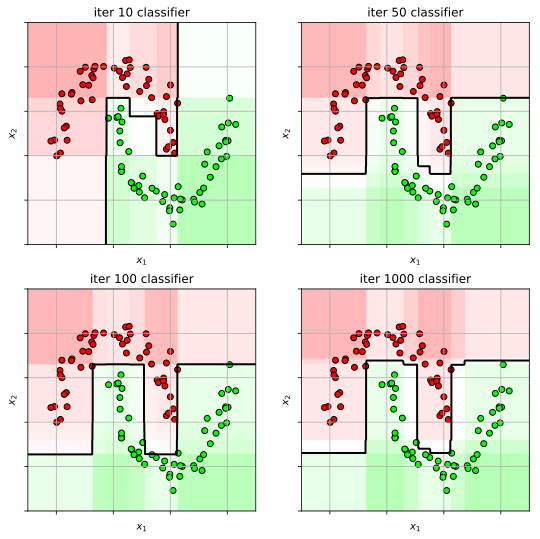

In [13]:
adafig

# Adaboost loss function
- exponential loss
  - $L(z_i) = e^{-z_i}$
    - $z_i = y_i  f(\mathbf{x}_i)$
  - very sensitive to misclassified outliers.

In [14]:
z = linspace(-6,6,100)
logloss = log(1+exp(-z))
hingeloss = maximum(0, 1-z)
exploss = exp(-z)
lossfig = plt.figure()
plt.plot(z,exploss, 'b-')

plt.plot([0,0], [0,9], 'k--')
plt.text(0,7.5, "incorrectly classified $\\Leftarrow$ ", ha='right', weight='bold')
plt.text(0,7.5, " $\Rightarrow$ correctly classified", ha='left', weight='bold')

plt.annotate(s="loss increases\nsignificantly for\nmisclassified\nsamples", 
             xy=(-1.6,5), xytext=(-3.5,2.2),backgroundcolor='white',
            arrowprops=dict(arrowstyle="->"))
plt.annotate(s="non-zero loss\nfor samples\nnear margin", 
             xy=(0.5,0.5), xytext=(0.5,3.2), backgroundcolor='white',
            arrowprops=dict(arrowstyle="->"))
plt.annotate(s="loss approaches\nzero for correctly\nclassified samples", 
             xy=(3,0.0), xytext=(1.5,1.1), backgroundcolor='white',
            arrowprops=dict(arrowstyle="->"))
plt.axis([-4, 4, 0, 8])
plt.grid(True)
plt.xlabel('$z_i$');
plt.ylabel('loss')
plt.title('exponential loss')
plt.close()

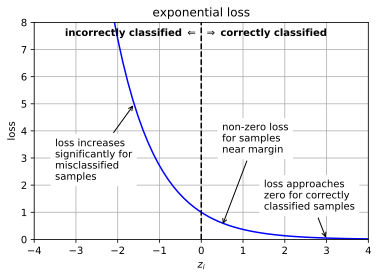

In [15]:
 lossfig

# Example on Iris data
- Too many weak-learners and AdaBoost carves out space for the outliers.

In [16]:
# load iris data each row is (petal length, sepal width, class)
irisdata = loadtxt('iris2.csv', delimiter=',', skiprows=1)

X = irisdata[:,0:2]  # the first two columns are features (petal length, sepal width)
Y = irisdata[:,2]    # the third column is the class label (versicolor=1, virginica=2)

print(X.shape)

(100, 2)


In [17]:
# randomly split data into 50% train and 50% test set
trainX, testX, trainY, testY = \
  model_selection.train_test_split(X, Y, 
  train_size=0.5, test_size=0.5, random_state=4487)

print(trainX.shape)
print(testX.shape)

(50, 2)
(50, 2)


In [18]:
ns = [1, 3, 5, 100]

clf = {}
for i,n in enumerate(ns):
    clf[n] = ensemble.AdaBoostClassifier(n_estimators=n, random_state=4487)
    clf[n].fit(trainX, trainY)
    
axbox = [2.5, 7, 1.5, 4]

irisfig = plt.figure(figsize=(9,8))
for i,n in enumerate(ns):
    clfx = clf[n]
    plt.subplot(2,2,i+1)
    plot_boosting(clfx, axbox, trainX)
    plt.scatter(trainX[:,0], trainX[:,1], c=trainY, cmap=mycmap, edgecolors='k')
    plt.xlabel('petal length'); plt.ylabel('sepal width')
    plt.gca().xaxis.set_ticklabels([])
    plt.gca().yaxis.set_ticklabels([])
    plt.title("n=" + str(n))
plt.close()

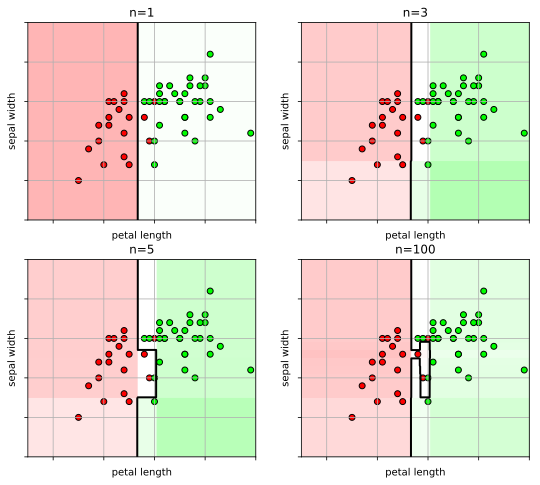

In [19]:
irisfig

- use cross-validation to select number of weak learners.

In [20]:
# setup the list of parameters to try
paramgrid = {'n_estimators': array([1, 2, 3, 5, 10, 15, 20, 25, 50, 100, 200, 500, 1000]) }
print(paramgrid)

# setup the cross-validation object
# (NOTE: using parallelization in GridSearchCV, not in AdaBoost)
adacv = model_selection.GridSearchCV(ensemble.AdaBoostClassifier(random_state=4487),
                                 paramgrid, cv=5, n_jobs=-1)

# run cross-validation (train for each split)
adacv.fit(trainX, trainY);

print("best params:", adacv.best_params_)

{'n_estimators': array([   1,    2,    3,    5,   10,   15,   20,   25,   50,  100,  200,
        500, 1000])}
best params: {'n_estimators': 2}


In [21]:
def extract_grid_scores(modelcv, paramgrid):
    "extract CV scores from GridSearchCV and put into a matrix"
    # get parameters
    pkeys = list(paramgrid.keys())
    
    # initialize empty score matrix
    scoresize = [len(paramgrid[p]) for p in pkeys]
    avgscores = zeros(scoresize)

    # fill in the matrix with run for each parameter set
    for rm,rp in zip(modelcv.cv_results_['mean_test_score'], modelcv.cv_results_['params']):
        # get the index into each of the parameter lists
        myind = [where(rp[p] == paramgrid[p]) for p in pkeys]
        avgscores[tuple(myind)] = rm    # put the score

    # location of best score
    bestind = [where(modelcv.best_params_[p] == paramgrid[p]) for p in pkeys]

    return avgscores, pkeys, bestind

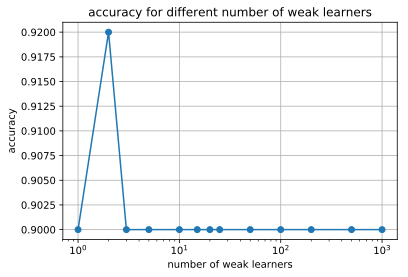

In [22]:
(avgscores, pnames, bestind) = extract_grid_scores(adacv, paramgrid)
paramfig = plt.figure()
plt.semilogx(paramgrid['n_estimators'], avgscores, 'o-')
plt.grid(True)
plt.ylabel('accuracy'); plt.xlabel('number of weak learners')
plt.title('accuracy for different number of weak learners')
plt.show()

In [23]:
# predict from the model
predY = adacv.predict(testX)

# calculate accuracy
acc      = metrics.accuracy_score(testY, predY)
print("test accuracy =", acc)

test accuracy = 0.82


In [24]:
ifig2 = plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
plot_boosting(adacv.best_estimator_, axbox, trainX)
plt.scatter(trainX[:,0], trainX[:,1], c=trainY, cmap=mycmap, edgecolors='k')
plt.xlabel('petal length'); plt.ylabel('sepal width')
plt.gca().xaxis.set_ticklabels([])
plt.gca().yaxis.set_ticklabels([])
plt.title("training data")

plt.subplot(1,2,2)
plot_boosting(adacv.best_estimator_, axbox, trainX)
plt.scatter(testX[:,0], testX[:,1], c=testY, cmap=mycmap, edgecolors='k')
plt.xlabel('petal length'); plt.ylabel('sepal width')
plt.gca().xaxis.set_ticklabels([])
plt.gca().yaxis.set_ticklabels([])
plt.title("testing data")
plt.close()

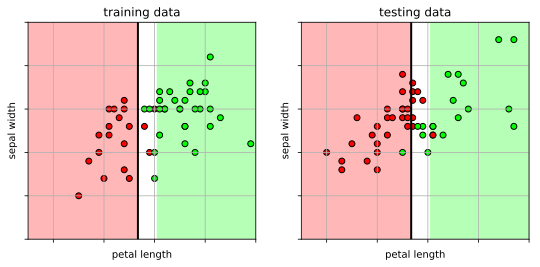

In [25]:
ifig2

- Boosting can do feature selection
  - each decision stump classifier looks at one feature
- One of the original face detection methods (Viola-Jones) used Boosting.
  - extract a lot of image features from the face
  - during training, Boosting learns which ones are the most useful.  
![](imgs/VJ-haar.png)

# AdaBoost Summary
- **Ensemble Classifier:**
  - Combine the outputs of many "weak" classifiers to make a "strong" classifier
- **Training:**
  - In each iteration, 
    - training data is re-weighted based on whether it is correctly classified or not.
    - weak classifier focuses on misclassified data from previous iterations.
  - Use cross-validation to pick number of weak learners.

- **Advantages:**
  - Good generalization performance
  - Built-in features selection - decision stump selects one feature at a time.
- **Disadvantages:**
  - Sensitive to outliers.

# Outline
1. Nonlinear classifiers
2. Kernel trick and kernel SVM
3. **Ensemble Methods - Boosting, Random Forests**
4. Classification Summary

# Decision Tree
- Simple "Rule-based" classifier
  - At each node, move down the tree based on that node's criteria.
  - leaf node contains the prediction
- **Advantage:** can create complex conjunction of rules
- **Disadvantage:** easy to overfit by itself
  - can fix with bagging!

<center>
<table><tr><td><img width="500" src="imgs/DT.png"></td><td><img width="500" src="imgs/DT-eg.png"></td></tr></table></center>

# Random Forest Classifier
- Use **bagging** to make an ensemble of Decision Tree Classifiers
  - for each _Decision Tree Classifier_
    - create a new training set by randomly sampling from the training set
    - for each split in a tree, select a random subset of features to use
- for a test sample, the prediction is aggregated over all trees.

<center><img src="imgs/RF.jpg"></center>

In [26]:
# learn a RF classifier
# use 4 trees
clf = ensemble.RandomForestClassifier(n_estimators=4, random_state=4487, n_jobs=-1)
clf.fit(X3, Y3)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=4, n_jobs=-1,
            oob_score=False, random_state=4487, verbose=0,
            warm_start=False)

In [27]:
def plot_rf(model, axbox, X):
    # grid points
    xr = [ linspace(axbox[0], axbox[1], 200), 
           linspace(axbox[2], axbox[3], 200) ]

    # make a grid for calculating the posterior, 
    #  then form into a big [N,2] matrix
    xgrid0, xgrid1 = meshgrid(xr[0], xr[1])
    allpts = c_[xgrid0.ravel(), xgrid1.ravel()]

    # calculate the decision function
    score = model.predict_proba(allpts)[:,1].reshape(xgrid0.shape)

    plt.imshow(score, origin='lower', extent=axbox, alpha=0.30, cmap=mycmap, 
               vmin=0, vmax=1, aspect='auto')

    plt.contour(xr[0], xr[1], score, levels=[0.5], linestyles='solid', colors='k')
    
    plt.axis(axbox); plt.grid(True)    

In [28]:
axbox = [-1.5, 2.5, -1, 1.5]

dtfig = plt.figure(figsize=(9,7))
for i,d in enumerate(clf.estimators_):
    plt.subplot(2,2,i+1)
    plot_rf(d, axbox, X3)
    plt.scatter(X3[:,0], X3[:,1], c=Y3, cmap=mycmap, edgecolors='k')
    plt.gca().xaxis.set_ticklabels([])
    plt.gca().yaxis.set_ticklabels([])
    plt.title("Decision Tree " + str(i+1))
plt.close()

rffig = plt.figure()
plot_rf(clf, axbox, X3)
plt.scatter(X3[:,0], X3[:,1], c=Y3, cmap=mycmap, edgecolors='k')
plt.colorbar()
plt.close()

- Here are the 4 decision trees 
  - each uses a different random sampling of original training set

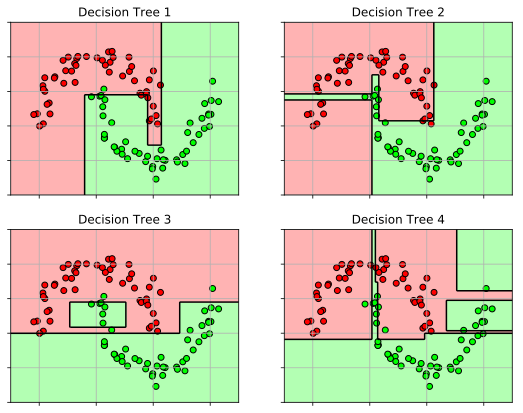

In [29]:
dtfig

- and the aggregated classifier

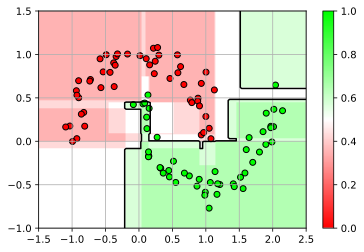

In [30]:
rffig

- Using more trees

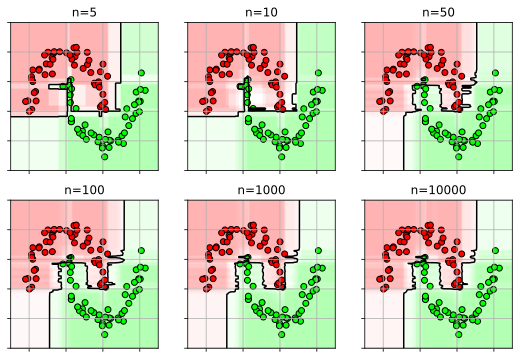

In [31]:
# learn RF classifiers for different n_estimators
plt.figure(figsize=(9,6))
clfs = {}
for i,n in enumerate([5, 10, 50, 100, 1000, 10000]):
    clfs[n] = ensemble.RandomForestClassifier(n_estimators=n, random_state=4487, n_jobs=-1)
    clfs[n].fit(X3, Y3)
        
    plt.subplot(2,3,i+1)
    plot_rf(clfs[n], axbox, X3)
    plt.scatter(X3[:,0], X3[:,1], c=Y3, cmap=mycmap, edgecolors='k')
    plt.gca().xaxis.set_ticklabels([])
    plt.gca().yaxis.set_ticklabels([])
    plt.title("n=" + str(n))
    

- Try on the iris data


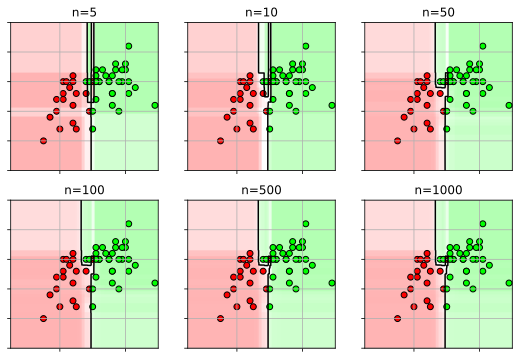

In [32]:
# learn RF classifiers for different n_estimators
plt.figure(figsize=(9,6))
clfs = {}
axbox = [2.5, 7, 1.5, 4]

for i,n in enumerate([5, 10, 50, 100, 500, 1000]):
    clfs[n] = ensemble.RandomForestClassifier(n_estimators=n, random_state=4487, n_jobs=-1)
    clfs[n].fit(trainX, trainY)
        
    plt.subplot(2,3,i+1)
    plot_rf(clfs[n], axbox, trainX)
    plt.scatter(trainX[:,0], trainX[:,1], c=trainY, cmap=mycmap, edgecolors='k')
    plt.gca().xaxis.set_ticklabels([])
    plt.gca().yaxis.set_ticklabels([])
    plt.title("n=" + str(n))

In [33]:
# predict from the model
predY = clfs[1000].predict(testX)

# calculate accuracy
acc      = metrics.accuracy_score(testY, predY)
print("test accuracy =", acc)

test accuracy = 0.8


In [34]:
axbox = [2.5, 7, 1.5, 4]

ifig3 = plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
plot_rf(clfs[1000], axbox, trainX)
plt.scatter(trainX[:,0], trainX[:,1], c=trainY, cmap=mycmap, edgecolors='k')
plt.xlabel('petal length'); plt.ylabel('sepal width')
plt.gca().xaxis.set_ticklabels([])
plt.gca().yaxis.set_ticklabels([])
plt.title("training data")

plt.subplot(1,2,2)
plot_rf(clfs[1000], axbox, trainX)
plt.scatter(testX[:,0], testX[:,1], c=testY, cmap=mycmap, edgecolors='k')
plt.xlabel('petal length'); plt.ylabel('sepal width')
plt.gca().xaxis.set_ticklabels([])
plt.gca().yaxis.set_ticklabels([])
plt.title("testing data")
plt.close()

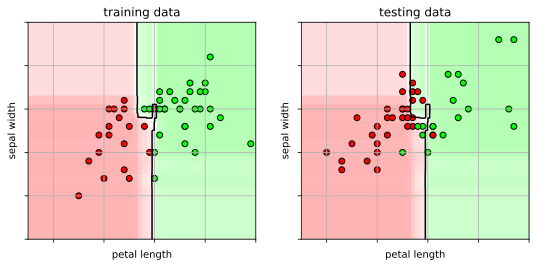

In [35]:
# classifier boundary w/ training and test data
ifig3

- Important parameters for cross-validation
  - `max_features` - maximum number of features used for each split
  - `max_depth` - maximum depth of a decision tree

# Outline
1. Nonlinear classifiers
2. Kernel trick and kernel SVM
3. Ensemble Methods - Boosting, Random Forests
4. **Classification Summary**

# Feature Pre-processing
- Some classifiers, such as SVM and LR, are sensitive to the scale of the feature values.
  - feature dimensions with larger values may dominate the objective function.
- Common practice is to _standardize_ or _normalize_ each feature dimension before learning the classifier.
  - Two Methods...

- **Method 1:** scale each feature dimension so the mean is 0 and variance is 1.
    - $\tilde{x}_d = \frac{1}{s}(x_d-m)$
    - $s$ is the standard deviation of feature values.
    - $m$ is the mean of the feature values.
- **NOTE:** the parameters for scaling the features should be estimated from the training set!
  - same scaling is applied to the test set.

In [36]:
# using the iris data
scaler = preprocessing.StandardScaler()  # make scaling object
trainXn = scaler.fit_transform(trainX)   # use training data to fit scaling parameters
testXn  = scaler.transform(testX)        # apply scaling to test data

In [37]:
nfig1 = plt.figure(figsize=(9,4))
axbox2 = [-3, 3, -3, 3]

plt.subplot(1,2,1)
plt.scatter(trainX[:,0], trainX[:,1], c=trainY, cmap=mycmap, edgecolors='k')
plt.xlabel('petal length'); plt.ylabel('sepal width')
plt.axis(axbox); plt.grid(True)
plt.axis('equal')
plt.title("unnormalized features")

plt.subplot(1,2,2)
plt.scatter(trainXn[:,0], trainXn[:,1], c=trainY, cmap=mycmap, edgecolors='k')
plt.xlabel('petal length'); plt.ylabel('sepal width')
plt.axis(axbox2); plt.grid(True)
plt.axis('equal')
plt.title("normalized features")
plt.close()

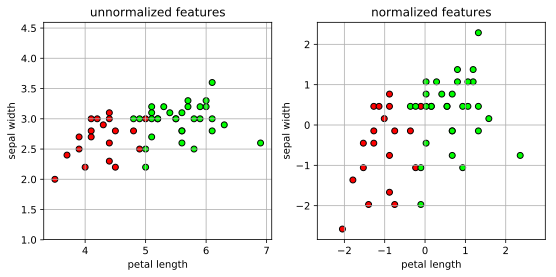

In [38]:
nfig1

- **Method 2:** scale features to a fixed range, -1 to 1.
  - $\tilde{x}_d = 2*(x_d - min) / (max-min) - 1$
  - $max$ and $min$ are the maximum and minimum features values.



In [39]:
# using the iris data
scaler = preprocessing.MinMaxScaler(feature_range=(-1,1))    # make scaling object
trainXn = scaler.fit_transform(trainX)   # use training data to fit scaling parameters
testXn  = scaler.transform(testX)        # apply scaling to test data

In [40]:
nfig2 = plt.figure(figsize=(9,4))
axbox2 = [-1, 1, -1, 1]

plt.subplot(1,2,1)
plt.scatter(trainX[:,0], trainX[:,1], c=trainY, cmap=mycmap, edgecolors='k')
plt.xlabel('petal length'); plt.ylabel('sepal width')

plt.axis(axbox); plt.grid(True)
plt.axis('equal')
plt.title("unnormalized features")

plt.subplot(1,2,2)
plt.scatter(trainXn[:,0], trainXn[:,1], c=trainY, cmap=mycmap, edgecolors='k')
plt.xlabel('petal length'); plt.ylabel('sepal width')
plt.axis(axbox2); plt.grid(True)
plt.axis('equal')
plt.title("normalized features [-1,1]")
plt.close()

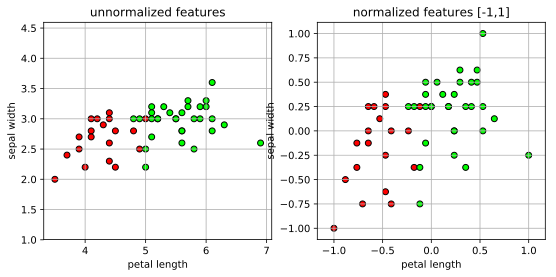

In [41]:
nfig2

# Data Representation and Feature Engineering
- How to represent data as a vector of numbers?
  - the encoding of the data into a feature vector should make sense
  - inner-products or distances calculated between feature vectors should be meaningful in terms of the data.

- Categorical variables
  - Example: $x$ has 3 possible category labels: cat, dog, horse
  - We could encode this as: $x=0$, $x=1$, and $x=2$.
    - Suppose we have two data points: $x = cat$, $x'=horse$.
    - What is the meaning of $x*x' = 2$?

# One-hot encoding
- encode a categorical variable as a vector of ones and zeros
  - if there are $K$ categories, then the vector is $K$ dimensions.
- Example:
  - x=cat $\rightarrow$ x=[1 0 0]
  - x=dog $\rightarrow$ x=[0 1 0]
  - x=horse $\rightarrow$ x=[0 0 1]

In [42]:
# one-hot encoding example
X = [[0], [1], [0], [2], [2]]  # original categorical data {0,1,2}
ohe = preprocessing.OneHotEncoder(sparse=False)
ohe.fit(X)         # finds the number of categories in the training set: 0-max(X)
ohe.transform(X)   # transform to one-hot-encoding

array([[1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.]])

# Binning
- encode a real value as a vector of ones and zeros
  - assign each feature value to a bin, and then use one-hot-encoding

In [43]:
# example
X = [[-3], [0.5], [1.5]]  # the data
bins = [-2,-1,0,1,2]      # define the bins

# map from value to bin number
Xbins = digitize(X, bins=bins)   

# map from bin number to 0-1 vector
ohe = preprocessing.OneHotEncoder(n_values=len(bins), sparse=False)
ohe.fit(Xbins)
ohe.transform(Xbins)

array([[1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]])

# Data transformations - polynomials
- Represent interactions between features using polynomials
- Example:
  - 2nd-degree polynomial models pair-wise interactions
    - $[x_1, x_2] \rightarrow [x_1^2, x_1 x_2, x_2^2]$
  - Combine with other degrees:
    - $[x_1, x_2] \rightarrow [1, x_1, x_2, x_1^2, x_1 x_2, x_2^2]$

In [44]:
X = [[0,1], [1,2], [3,4]]
pf = preprocessing.PolynomialFeatures(degree=2)
pf.fit(X)
pf.transform(X) 

array([[ 1.,  0.,  1.,  0.,  0.,  1.],
       [ 1.,  1.,  2.,  1.,  2.,  4.],
       [ 1.,  3.,  4.,  9., 12., 16.]])

# Data transformations - univariate
- Apply a non-linear transformation to the feature
  - e.g., x $\rightarrow$ log(x)
  - useful if the dynamic range of x is very large

# Unbalanced Data
- For some classification tasks that data will be unbalanced
  - many more examples in one class than the other.
- **Example:** detecting credit card fraud
  - credit card fraud is rare
    - 50 examples of fraud, 5000 examples of legitimate transactions.

In [45]:
# generate random data
X,Y = datasets.samples_generator.make_blobs(n_samples=200, 
         centers=[[0,0]], cluster_std=2, n_features=2, random_state=4487)
X2,Y2 = datasets.samples_generator.make_blobs(n_samples=20, 
         centers=[[3,3]], cluster_std=0.5, n_features=2, random_state=4487)

X = r_[X,X2]
Y = r_[Y,Y2+1]

udatafig = plt.figure()
plt.scatter(X[:,0],X[:,1],c=Y,cmap=mycmap, edgecolors='k')
plt.grid(True)
plt.title('class 0: 200 points; class 1: 20 points')
plt.close()

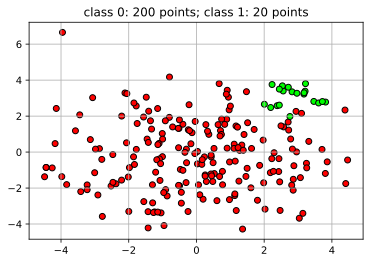

In [46]:
udatafig

- Unbalanced data can cause problems when training the classifier
  - classifier will focus more on the class with more points.
  - decision boundary is pushed away from  class with more points

In [47]:
clf = svm.SVC(kernel='linear', C=10)
clf.fit(X, Y)

udatafig1 = plt.figure()
plt.scatter(X[:,0],X[:,1],c=Y,cmap=mycmap, edgecolors='k')

w = clf.coef_[0]
b = clf.intercept_[0]
l1 = drawplane(w, b, lw=2, ls='k-')
plt.legend((l1,), ('SVM decision boundary',), fontsize=9)
plt.axis([-6, 7, -6, 7])
plt.grid(True)
plt.close()

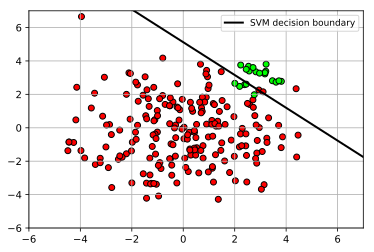

In [48]:
udatafig1

- **Solution:** apply weights on the classes during training.
  - weights are inversely proportional to the class size.

In [49]:
clfw = svm.SVC(kernel='linear', C=10,  class_weight='balanced')
clfw.fit(X, Y)

print("class weights =", clfw.class_weight_)

class weights = [0.55 5.5 ]


In [50]:
udatafig2 = plt.figure()
plt.scatter(X[:,0],X[:,1],c=Y,cmap=mycmap, edgecolors='k')

w = clf.coef_[0]
b = clf.intercept_[0]
ww = clfw.coef_[0]
bw = clfw.intercept_[0]
l1 = drawplane(w, b, lw=2, ls='k--')
l2 = drawplane(ww, bw, lw=2, ls='k-')
plt.legend((l1,l2), ('unweighted', 'weighted'), fontsize=9)
plt.axis([-6, 7, -6, 7])
plt.grid(True)
plt.close()

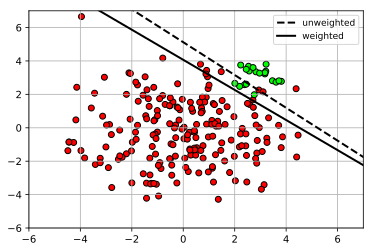

In [51]:
udatafig2

# Classifier Imbalance
- In some tasks, errors on certain classes cannot be tolerated.
- **Example:** detecting spam vs non-spam
  - non-spam should _definitely not_ be marked as spam
    - okay to mark some spam as non-spam

In [52]:
X,Y = datasets.samples_generator.make_blobs(n_samples=200, 
         centers=[[-3,0],[3,0]], cluster_std=2, n_features=2, random_state=447)
udatafig3 = plt.figure()
plt.scatter(X[:,0], X[:,1], c=Y, cmap=mycmap, edgecolors='k')
plt.grid(True)
plt.close()

clf = svm.SVC(kernel='linear', C=10)
clf.fit(X, Y)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

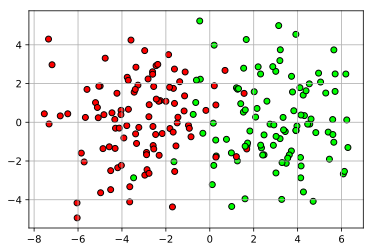

In [53]:
udatafig3

- Class weighting can be used to make the classifier focus on certain classes
  - e.g., weight non-spam class higher than spam class
    - classifier will try to correctly classify all non-spam samples, at the expense of making errors on spam samples.

In [54]:
# dictionary (key,value) = (class name, class weight)
cw = {0: 0.2, 
      1:  5}  # class 1 is 25 times more important!

clfw = svm.SVC(kernel='linear', C=10,  class_weight=cw)
clfw.fit(X, Y);

In [55]:
udatafig4 = plt.figure()
plt.scatter(X[:,0], X[:,1], c=Y, cmap=mycmap, edgecolors='k')
plt.grid(True)

w = clf.coef_[0]
b = clf.intercept_[0]
ww = clfw.coef_[0]
bw = clfw.intercept_[0]
l1 = drawplane(w, b, lw=2, ls='k--')
l2 = drawplane(ww, bw, lw=2, ls='k-')
plt.legend((l1,l2), ('unweighted', 'weighted'), fontsize=9)
plt.axis([-10, 8, -6, 6])

plt.close()

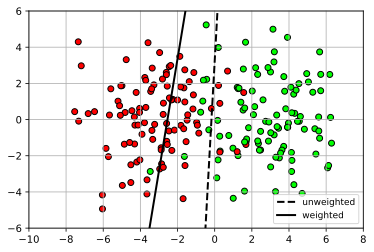

In [56]:
udatafig4

# Classification Summary

- **Classification task**
  - Observation $\mathbf{x}$: typically a real vector of feature values, $\mathbf{x}\in\mathbb{R}^d$.
  - Class $y$: from a set of possible classes, e.g., ${\cal Y} = \{0,1\}$
  - **Goal:** given an observation $\mathbf{x}$, predict its class $y$.
    
<table style="font-size:9pt;">
<tr>
<th>Name</th>
<th>Type</th>
<th>Classes</th>
<th>Decision function</th>
<th>Training</th>
<th>Advantages</th>
<th>Disadvantages</th>
</tr>
<tr>
<td>Bayes' classifier</td>
<td>generative</td>
<td>multi-class</td>
<td>non-linear</td>
<td>estimate class-conditional densities $p(x|y)$ by maximizing likelihood of data.</td>
<td>- works well with small amounts of data.<br>- multi-class.<br>- minimum probability of error if probability models are correct.</td>
<td>- depends on the data correctly fitting the class-conditional.</td>
</tr>
<tr>
<td>logistic regression</td>
<td>discriminative</td>
<td>binary</td>
<td>linear</td>
<td>maximize likelihood of data in $p(y|x)$.</td>
<td>- well-calibrated probabilities.<br>- efficient to learn.</td>
<td>- linear decision boundary.<br>- sensitive to $C$ parameter.</td>
</tr>
<tr>
<td>support vector machine (SVM)</td>
<td>discriminative</td>
<td>binary</td>
<td>linear</td>
<td>maximize the margin (distance between decision surface and closest point).</td>
<td>- works well in high-dimension.<br>- good generalization.</td>
<td>- linear decision boundary.<br>- sensitive to $C$ parameter.</td>
</tr>
<tr>
<td>kernel SVM</td>
<td>discriminative</td>
<td>binary</td>
<td>non-linear (kernel function)</td>
<td>maximize the margin.</td>
<td>- non-linear decision boundary.<br>- can be applied to non-vector data using appropriate kernel.</td>
<td>- sensitive to kernel function and hyperparameters.<br>
- high memory usage for large datasets</td>
</tr>
<tr>
<td>AdaBoost</td>
<td>discriminative</td>
<td>binary</td>
<td>non-linear (ensemble of weak learners)</td>
<td>train successive weak learners to focus on misclassified points.</td>
<td>- non-linear decision boundary. can do feature selection.<br>- good generalization.</td>
<td>- sensitive to outliers.</td>
</tr>
<tr>
<td>Random Forest</td>
<td>discriminative</td>
<td>multi-class</td>
<td>non-linear (ensemble of decision trees)</td>
<td>aggregate predictions over several decision trees, trained using different subsets of data.</td>
<td>- non-linear decision boundary. can do feature selection.<br>- good generalization.<br>- fast</td>
<td>- sensitive to outliers.</td>
</tr>
</table>

# Loss functions
- The classifiers differ in their loss functions, which influence how they work.
  - $z_i = y_i f(\mathbf{x}_i)$

In [57]:
z = linspace(-6,6,100)
logloss = log(1+exp(-z)) / log(2)
hingeloss = maximum(0, 1-z)
exploss = exp(-z)
lossfig = plt.figure()

plt.plot([0,0], [0,9], 'k--')
plt.text(0,8.5, "incorrectly classified $\\Leftarrow$ ", ha='right', weight='bold')
plt.text(0,8.5, " $\Rightarrow$ correctly classified", ha='left', weight='bold')

plt.plot(z,hingeloss, 'b-', label='hinge (SVM)')
plt.plot(z,logloss, 'r-', label='logistic (LR)')
plt.plot(z,exploss, 'g-', label='exponential (AdaBoost)')
plt.axis([-6,6,0,9]); plt.grid(True)
plt.xlabel('$z_i$');
plt.ylabel('loss')
plt.legend(loc='right', fontsize=10)
plt.title('loss functions')
plt.close()

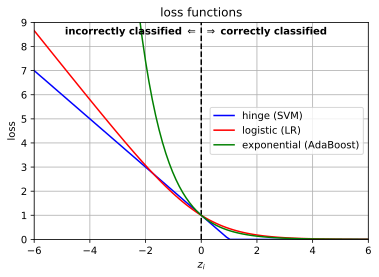

In [58]:
lossfig

# Regularization and Overfitting
- Some models have terms to prevent overfitting the training data.
  - this can improve _generalization_ to new data.
- There is a parameter to control the regularization effect.
  - select this parameter using cross-validation on the training set.

In [59]:
X,Y = datasets.samples_generator.make_blobs(n_samples=100, 
         centers=[[-3,0],[3,0]], cluster_std=1.5, n_features=2, random_state=447)
udatafig3 = plt.figure()
axbox = [-10,8,-6,6]
xr = [linspace(axbox[0], axbox[1], 50), linspace(axbox[2], axbox[3], 50)]

Cs = [0.1, 10, 100]
clf={}

ofig = plt.figure(figsize=(9,3))
for i,C in enumerate(Cs):
    clf[C] = svm.SVC(kernel='rbf', C=C, gamma=0.05)
    clf[C].fit(X, Y)
    
    # make a grid for calculating the posterior, 
    #  then form into a big [N,2] matrix
    xgrid0, xgrid1 = meshgrid(xr[0], xr[1])
    allpts = c_[xgrid0.ravel(), xgrid1.ravel()]

    score = clf[C].decision_function(allpts).reshape(xgrid0.shape)

    cmap = ([1,0,0], [1,0.7,0.7], [0.7,1,0.7], [0,1,0])
    
    plt.subplot(1,len(Cs),i+1)
    plt.contourf(xr[0], xr[1], score, colors=cmap, 
             levels=[-1000, -1, 0, 1, 1000], alpha=0.3)
    plt.contour(xr[0], xr[1], score, levels=[-1, 1], linewidths=1, linestyles='dashed', colors='k')
    plt.contour(xr[0], xr[1], score, levels=[0], linestyles='solid', colors='k')

    plt.scatter(X[:,0], X[:,1], c=Y, cmap=mycmap, edgecolors='k')
    
    #plt.plot(clf.support_vectors_[:,0], clf.support_vectors_[:,1],
    #         'ko',fillstyle='none', markeredgewidth=2)
    plt.axis(axbox); plt.grid(True)
    plt.title('C='+str(C))
plt.close()

<Figure size 432x288 with 0 Axes>

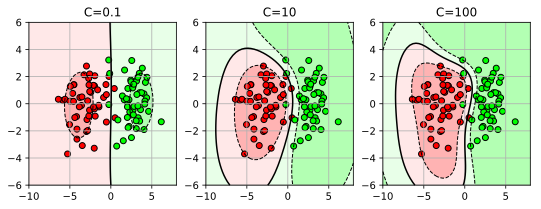

In [60]:
ofig

# Other things
- *Multiclass classification*
  - can use binary classifiers to do multi-class using _1-vs-rest_ formulation.
- *Feature normalization*
  - normalize each feature dimension so that some feature dimensions with larger ranges do not dominate the optimization process.
- *Unbalanced data*
  - if more data in one class, then apply weights to each class to balance objectives.
- *Class imbalance*
  - mistakes on some classes are more critical.
  - reweight class to focus classifier on correctly predicting one class at the expense of others.

# Applications
- Web document classification, spam classification
- Face gender recognition, face detection, digit classification

# Features
- Choice of features is important!
  - using uninformative features may confuse the classifier.
  - use domain knowledge to pick the best features to extract from the data.

# Which classifier is best?
- **"No Free Lunch" Theorem** (Wolpert and Macready)
  
> "If an algorithm performs well on a certain class of problems then it necessarily pays for that with degraded performance on the set of all remaining problems."
  
  - In other words, there is no *best* classifier for all tasks.  The best classifier depends on the particular problem.